# Exercício 1 de Análise de Componentes Independentes em imagens


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.cluster.vq import whiten
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import entropy, chi2_contingency, shapiro
from scipy.misc import imread

%matplotlib inline
from evaluation import calculateNegentropy, kde_entropy, KLdivergence, resultsTable, plot_MutualInformation
from ICAfunctions import cichocki_Feedback, cichocki_Feedforward, NPCA_RLS

#Notes:
#SHAPIRO: The algorithm used is described in [R634] but censoring parameters as 
#        described are not implemented. For N > 5000 the W test statistic is 
#        accurate but the p-value may not be.

In [2]:
def rebuildPicture(x, original_shape):
    rebuilt = np.zeros(original_shape, np.float64)
    rebuilt[:, :, 0] = np.reshape(x[:, 0], (original_shape[0], original_shape[1]))
    rebuilt[:, :, 1] = np.reshape(x[:, 1], (original_shape[0], original_shape[1]))
    rebuilt[:, :, 2] = np.reshape(x[:, 2], (original_shape[0], original_shape[1]))
    
    return rebuilt

def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)


def rgb_ICA(ICA_method, mixturesRGB, learningRate):
    #y = np.zeros(mixturesRGB.shape)

    print(mixturesRGB[0].shape)
    
    [y_r, Wr] = ICA_method(mixturesRGB[:, :, 0], learningRate)
    [y_g, Wg] = ICA_method(mixturesRGB[:, :, 1], learningRate)
    [y_b, Wb] = ICA_method(mixturesRGB[:, :, 2], learningRate)

    y = np.dstack((y_r, y_g, y_b))
    
    plt.imshow(np.reshape(y[0,:,0], (400, 500)))
    plt.show()
    
    W = [Wr, Wg, Wb]
    #W = Wr
    
    return y, W



def read_rgb_image(folderPath, n_images = 2, n_channels = 3):
    X1 = imread(folderPath + '\\1_saida.jpg', flatten = False)
    X2 = imread(folderPath + '\\2_saida.jpg', flatten = False)
    
    mixtures = np.zeros((n_images, X1.shape[0]*X1.shape[1], n_channels), np.float64)

    mixtures[0, :, 0] = X1[:,:,0].flatten()
    mixtures[0, :, 1] = X1[:,:,1].flatten()
    mixtures[0, :, 2] = X1[:,:,2].flatten()
    
    mixtures[1, :, 0] = X2[:,:,0].flatten()
    mixtures[1, :, 1] = X2[:,:,1].flatten()
    mixtures[1, :, 2] = X2[:,:,2].flatten()   
    
    original_shape = X1.shape

    return mixtures, original_shape


In [3]:
learning_rate = 1e-6
n_images = 2

In [4]:
folderPath = 'base_imagens_ica\\1_run'
mixtures, original_shape = read_rgb_image(folderPath)
print(mixtures.shape)
print(original_shape)

(2, 200000, 3)
(400, 500, 3)


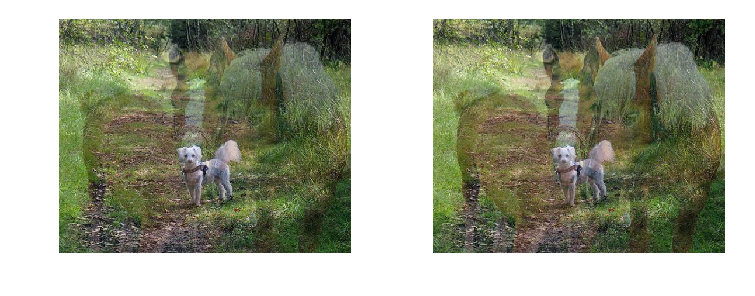

In [5]:
picture1 = rebuildPicture(mixtures[0], original_shape)
picture2 = rebuildPicture(mixtures[1], original_shape)

fig, axes = plt.subplots(1,2, dpi = 128)
axes[0].imshow(-picture1)
axes[1].imshow(-picture2)
axes[0].axis('off')
axes[1].axis('off')

fig.tight_layout()

## NPCA-RLS Algorithm

(200000, 3)
Execution time: 52.439422845840454 seconds
Execution time: 52.40774321556091 seconds
Execution time: 49.63296389579773 seconds


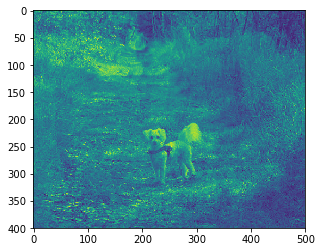

In [6]:
[yNPCA, WNPCA] = rgb_ICA(NPCA_RLS, mixtures, (1/1+1e-9))

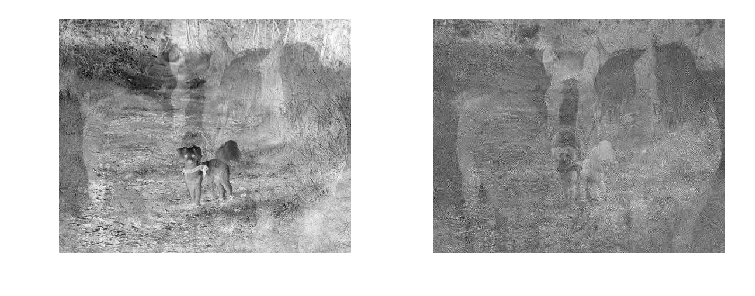

In [7]:
fig, axes = plt.subplots(1,2, dpi = 128)

axes[0].imshow(np.reshape(-yNPCA[0,:,1], (400,500)), cmap = 'gray')
axes[1].imshow(np.reshape(yNPCA[1,:,1], (400,500)), cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')
fig.tight_layout()

## Cichocki-Unbehauen Algorithm Feedback Network

(200000, 3)
Execution time: 71.78996348381042 seconds
Execution time: 72.4551637172699 seconds
Execution time: 71.74628257751465 seconds


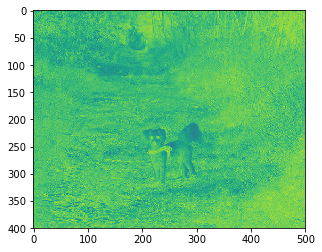

In [8]:
[yFeedback, WFeedback] = rgb_ICA(cichocki_Feedback, mixtures, 5e-1)

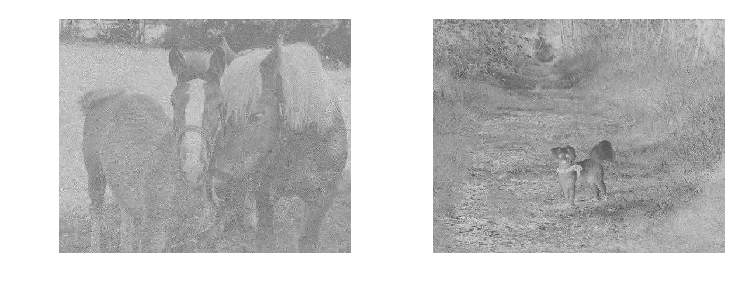

In [9]:
fig, axes = plt.subplots(1,2, dpi = 128)

axes[0].imshow(np.reshape(-yFeedback[0,:,1], (400,500)), cmap = 'gray')
axes[1].imshow(np.reshape(yFeedback[1,:,1], (400,500)), cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')
fig.tight_layout()

## Cichocki-Unbehauen Algorithm Feedforward Network

(200000, 3)
Execution time: 54.81574273109436 seconds
Execution time: 48.354564905166626 seconds
Execution time: 45.85443162918091 seconds


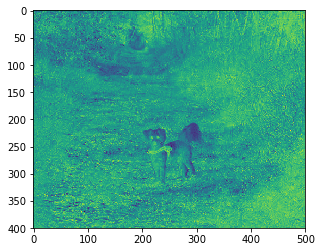

In [10]:
[yFeedForward, WFeedforward] = rgb_ICA(cichocki_Feedforward, mixtures, 1.5e-1)

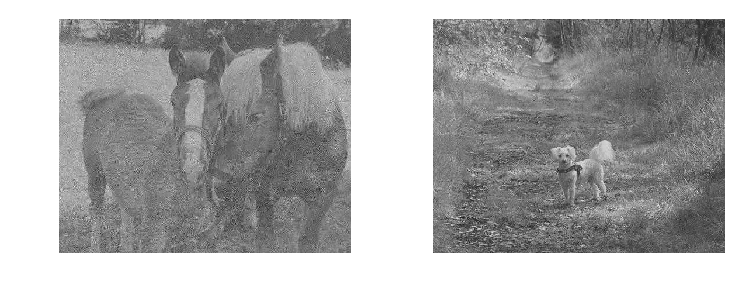

In [11]:
fig, axes = plt.subplots(1,2, dpi = 128)

axes[0].imshow(np.reshape(yFeedForward[0,:,1], (400,500)), cmap = 'gray')
axes[1].imshow(np.reshape(yFeedForward[1,:,1], (400,500)), cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')
fig.tight_layout()